# Titanic competition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
data_file = pd.read_csv('./train.csv')

## Finding null values and fixing them

In [2]:
print('\n Before manipulating: \n',data_file.isnull().sum())
data_file.drop(['PassengerId','Cabin','Ticket'], axis = 1, inplace = True)


 Before manipulating: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Following is the logic to fill the empty value of the age. Comb through the names and see if there is "Master" then it has to be a boy, assign the mean age of the boys. For men check the names against 'Mr.'. For all the names with "Miss", it can either be a single woman or a little girl, in which case the second condition will be to check the age, if less than 18 use the mean of all female people who are below 18 years. If more than 18 then use the mean of all females above 18. Apart from this 'Mrs' also qualifies for women who are above 18, hence factor this as well.

In [3]:
data_file.drop(data_file[data_file.Embarked.isnull()].index,axis = 0, inplace = True)
data_file.reset_index(drop = True, inplace = True)
age_filter = data_file.Age < 18
age_null_filter = data_file.Age.isnull()
name_filter_master = data_file.Name.str.contains("Master")
name_filter_mister = data_file.Name.str.contains("Mr")
name_filter_missus = data_file.Name.str.contains("Mrs")
name_filter_miss = data_file.Name.str.contains("Miss")
mean_age_boys = data_file[name_filter_master].Age.mean()
mean_age_girls = data_file[name_filter_miss & age_filter].Age.mean()
mean_age_women = data_file[(name_filter_miss & ~age_filter) | name_filter_missus].Age.mean()
mean_age_men = data_file[name_filter_mister].Age.mean()
data_file.loc[age_null_filter & name_filter_mister,'Age'] = mean_age_men
data_file.loc[age_null_filter & name_filter_master,'Age'] = mean_age_boys
data_file.loc[age_null_filter & name_filter_miss & age_filter,'Age'] = mean_age_girls
data_file.loc[age_null_filter & (name_filter_miss & ~age_filter) | name_filter_missus,'Age'] = mean_age_women
#There is one person whose age is missing and he does not have Mr in his name. 
#So this person's age will be replaced by mean age of men
data_file.loc[~name_filter_master & ~name_filter_mister & ~name_filter_missus & ~name_filter_miss & age_null_filter,'Age'] = mean_age_men
print('\n After filling the age columns, the coloumns with NAN values are: \n', data_file.isnull().sum())
# Dropping the name column and the two rows where Embarked data was left out
data_file.drop(columns ='Name',inplace = True)
data_file.head(5)


 After filling the age columns, the coloumns with NAN values are: 
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,32.428571,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,32.428571,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S


## Converting categorical data to numerical values

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()
ohe = OneHotEncoder()

temp_embark = ohe.fit_transform(data_file.iloc[:,1:2].values).toarray()
temp_embark = pd.DataFrame(temp_embark)
temp_embark.columns = ['Cherbourg','Queenstown','Southampton']

temp_pclass = ohe.fit_transform(data_file.iloc[:,7:8].values).toarray()
temp_pclass = pd.DataFrame(temp_pclass)
temp_pclass.columns = ['Upper','Middle','Lower']

temp_sex = le.fit_transform(data_file.Sex)
temp_sex = pd.DataFrame(temp_sex)
temp_sex.columns = ['Sex']

## Data visualization

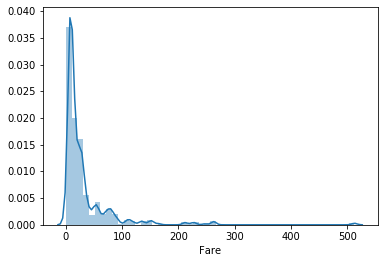

In [5]:
#sns.boxplot(x ='Fare', hue = 'Survived', data = data_file)
data_file.describe()
survived_filter = data_file.Survived == 1
fare_filter = data_file.Fare.isin([10,50])
embark_filter = temp_embark.Queenstown == 1
#data_file[~survived_filter & ~age_filter].describe()
#sns.distplot(data_file[~survived_filter].Age)
#sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = data_file)
sns.distplot(data_file.Fare)

## Feature engineering

The model was run initially with low scores on the test data. Feature engineering concepts like combining features or adding new features will be tried out here. 

### Adding a new column to bin people into different age groups and bin fare

,Lvl 1,Lvl 2,Lvl 3,Lvl 4,Lvl 5,Lvl 6,Lvl 7,Lvl 8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


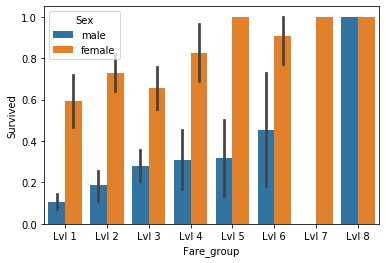

In [6]:
age_bins = [-1,5,11,19,30,50,120]
age_groups = ['Infant','Kid','Teenagers','Adults','Middle-age','Old']
data_file['Age_group'] = pd.cut(data_file.Age, age_bins, labels = age_groups)
#sns.barplot(x = 'Age_group', y = 'Survived', hue = 'Sex', data = data_file)
#data_file
# Doing one hot encoding to conver this data into numbers
temp_age_grp = ohe.fit_transform(data_file.iloc[:,8:9].values).toarray()
temp_age_grp = pd.DataFrame(temp_age_grp)
temp_age_grp.columns = ['Infant','Kid','Teenagers','Adults','Middle-age','Old']
temp_age_grp.head(4)
fare_bins = [-1,10,20,40,70,100,200,400,600]
fare_grps = ['Lvl 1','Lvl 2','Lvl 3','Lvl 4','Lvl 5','Lvl 6','Lvl 7','Lvl 8']
data_file['Fare_group'] = pd.cut(data_file.Fare, fare_bins, labels = fare_grps)
sns.barplot(x = 'Fare_group', y = 'Survived', hue = 'Sex', data = data_file)
temp_fare_grp = ohe.fit_transform(data_file.iloc[:,9:10].values).toarray()
temp_fare_grp = pd.DataFrame(temp_fare_grp)
temp_fare_grp.columns = ['Lvl 1','Lvl 2','Lvl 3','Lvl 4','Lvl 5','Lvl 6','Lvl 7','Lvl 8']
temp_fare_grp.head(4)

## Splitting the data and rescaling the features

In [7]:
#X = data_file[['Fare']].copy()
Y = data_file[['Survived']].copy()
X = pd.concat([temp_embark, temp_sex, temp_age_grp, temp_pclass, temp_fare_grp], axis = 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
n_scaler = MinMaxScaler()
s_scaler = StandardScaler()
x_train = s_scaler.fit_transform(x_train)
x_test = s_scaler.transform(x_test)
#sns.distplot(x_train[:,0])

## Linear logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression
lor = LogisticRegression()
lor.fit(x_train, y_train.values.ravel())
y_train_predict = lor.predict(x_train)
y_test_predict = lor.predict(x_test)
print('\n Goodness of fit of linear model training followed by test data \n', lor.score(x_train, y_train),'\n', lor.score(x_test, y_test))



 Goodness of fit of linear model training followed by test data 
 0.8487394957983193 
 0.7789115646258503


## Polynomial regression

In [11]:
from sklearn.preprocessing import PolynomialFeatures
polyf = PolynomialFeatures(degree = 3)
x_poly = polyf.fit_transform(X)
x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(x_poly, Y, test_size=0.33, random_state=0)
x_train_pf = s_scaler.fit_transform(x_train_pf)
x_test_pf = s_scaler.transform(x_test_pf)
lor.fit(x_train_pf, y_train_pf)
print('\n Goodness of fit of polynomical model training followed by test data \n', lor.score(x_train_pf, y_train_pf),'\n', lor.score(x_test_pf, y_test_pf))


 Goodness of fit of polynomical model training followed by test data 
 0.8907563025210085 
 0.7448979591836735


## Support vector Machine

In [20]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', gamma = 0.01)
svc.fit(x_train, y_train.values.ravel())
print('\n Goodness of fit of SVC training followed by test data \n', svc.score(x_train, y_train),'\n', svc.score(x_test, y_test))


 Goodness of fit of SVC training followed by test data 
 0.8285714285714286 
 0.7755102040816326


## K-Nearest neighbours

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'kd_tree')
knn.fit(x_train, y_train.values.ravel())
print('\n Goodness of fit of SVC training followed by test data \n', knn.score(x_train, y_train),'\n', knn.score(x_test, y_test))


 Goodness of fit of SVC training followed by test data 
 0.8890756302521008 
 0.7244897959183674


## Using Cross-Validation technique to choose the best model

## Preparing test file to predict the output

In [54]:
test_file = pd.read_csv('./test.csv')
test_file.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


In [55]:
# Counting the NaN values in the data set
print('\n The number of NaN values in the data are: \n', test_file.isnull().sum())


 The number of NaN values in the data are: 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Using the same method as above to fill the missing age in the test data set.

In [56]:
age_filter = test_file.Age < 18
age_null_filter = test_file.Age.isnull()
name_filter_master = test_file.Name.str.contains("Master")
name_filter_mister = test_file.Name.str.contains("Mr")
name_filter_missus = test_file.Name.str.contains("Mrs")
name_filter_miss = test_file.Name.str.contains("Miss")
mean_age_boys = test_file[name_filter_master].Age.mean()
mean_age_girls = test_file[name_filter_miss & age_filter].Age.mean()
mean_age_women = test_file[(name_filter_miss & ~age_filter) | name_filter_missus].Age.mean()
mean_age_men = test_file[name_filter_mister].Age.mean()
test_file.loc[age_null_filter & name_filter_mister,'Age'] = mean_age_men
test_file.loc[age_null_filter & name_filter_master,'Age'] = mean_age_boys
test_file.loc[age_null_filter & name_filter_miss & age_filter,'Age'] = mean_age_girls
test_file.loc[age_null_filter & (name_filter_miss & ~age_filter) | name_filter_missus,'Age'] = mean_age_women
test_file.loc[~name_filter_master & ~name_filter_mister & ~name_filter_missus & ~name_filter_miss & age_null_filter,'Age'] = mean_age_men
print('\n The number of NaN values in the data after filling age column are: \n', test_file.isnull().sum())


 The number of NaN values in the data after filling age column are: 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Converting the categorical data to numerical values as above

In [ ]:
temp_embark = ohe.fit_transform(test_file.iloc[:,10:11].values).toarray()
temp_embark = pd.DataFrame(temp_embark)
temp_embark.columns = ['Cherbourg','Queenstown','Southampton']

temp_pclass = ohe.fit_transform(test_file.iloc[:,1:2].values).toarray()
temp_pclass = pd.DataFrame(temp_pclass)
temp_pclass.columns = ['Upper','Middle','Lower']

temp_sex = le.fit_transform(test_file.Sex)
temp_sex = pd.DataFrame(temp_sex)
temp_sex.columns = ['Sex']

age_group = le.fit_transform(age_filter)
age_group = pd.DataFrame(age_group)
age_group.columns = ['Age group']

### Splitting and rescaling features

In [ ]:
X = pd.concat([temp_embark, temp_sex, age_group, temp_pclass], axis = 1)
X_predict = s_scaler.transform(X)

### Predicting the survival status of the test subjects

In [ ]:
X.head(4)
#print(X.isnull().sum())
Y_test_predict = lor.predict(X_predict)
Y_test_predict = pd.DataFrame(Y_test_predict)
Y_test_predict.columns = ['Survived']
Y_test_predict.head(6)

## Saving the predicted data in the CSV file

In [ ]:
sub_file = pd.read_csv('./gender_submission.csv')
sub_file.head(4)

In [ ]:
sub_file.drop(columns = ['Survived'],  inplace = True)
sub_file = pd.concat([sub_file, Y_test_predict], axis = 1)
sub_file.head(6)

In [ ]:
sub_file.to_csv('./gender_submission.csv', index = False)